<a href="https://colab.research.google.com/github/Drath10/Muzzle-Print-Recognition/blob/main/OneShot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import pickle
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rng
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Conv2D, Flatten, MaxPooling2D, Dense, Lambda
from keras.models import Model, Sequential
from keras.regularizers import l2
from sklearn.utils import shuffle

In [ ]:
tr_path = os.path.join('/content/drive/MyDrive/AI Project',"train.pickle")
val_path = os.path.join('/content/drive/MyDrive/AI Project',"val.pickle")

In [ ]:
with open(tr_path, "rb") as f:
	X_train, train_classes = pickle.load(f)

with open(val_path, "rb") as f:
	X_val, val_classes = pickle.load(f)

In [ ]:
init_w = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=rng.randint(-1e6, 1e6))
init_b = tf.keras.initializers.RandomNormal(mean=0.5, stddev=0.01, seed=rng.randint(-1e6, 1e6))

In [ ]:
def get_model(input_shape):
  left_input = Input(input_shape)
  right_input = Input(input_shape)

  model = Sequential()

  model.add(Conv2D(96, (11,11), strides=4, activation='relu', input_shape=input_shape, kernel_initializer=init_w, kernel_regularizer=l2(2e-4)))
  model.add(MaxPooling2D(pool_size=(3,3), strides=2))

  model.add(Conv2D(256, (5,5), padding='same', activation='relu', kernel_initializer=init_w, kernel_regularizer=l2(2e-4)))
  model.add(MaxPooling2D(pool_size=(3,3), strides=2))

  model.add(Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=init_w, bias_initializer=init_b, kernel_regularizer=l2(2e-4)))
  model.add(MaxPooling2D(pool_size=(3,3), strides=2))

  model.add(Flatten())
  model.add(Dense(4096, activation='sigmoid', kernel_regularizer=l2(1e-3), kernel_initializer=init_w, bias_initializer=init_b))

  encoded_l = model(left_input)
  encoded_r = model(right_input)

  L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
  L1_distance = L1_layer([encoded_l, encoded_r])

  prediction = Dense(1, activation='sigmoid', bias_initializer=init_b)(L1_distance)

  siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

  return siamese_net

In [ ]:
def get_batches(batch_size, s='train'):
  if s=='train':
    X = X_train
    categories = train_classes
  else:
    X = X_val
    categories = val_classes

  n_classes, n_examples, w, h = X.shape
  categories = rng.choice(n_classes, size=(batch_size,), replace=False)

  pairs = [np.zeros((batch_size, h, w, 1)), np.zeros((batch_size, h, w, 1))]
  targets = np.zeros((batch_size,))

  targets[batch_size//2:] = 1
  for i in range(batch_size):
    category = categories[i]
    idx_1 = rng.randint(0, n_examples)
    pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
    idx_2 = rng.randint(0, n_examples)

    if i >= batch_size // 2:
      category_2 = category
    else:
      category_2 = (category + rng.randint(1,n_classes)) % n_classes

    pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
  return pairs, targets

def generate(batch_size, s):
  while True:
    pairs, target = get_batches(batch_size, s)
    yield (pairs, targets)

In [ ]:
model = get_model((224,224,1))
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.00006))
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential_2 (Sequential)      (None, 4096)         27434944    ['input_5[0][0]',                
                                                                  'input_6[0][0]']          

In [ ]:
def make_oneshot_task(N, s="val"):
  if s == 'train':
    X = X_train
    categories = train_classes
  else:
    X = X_val
    categories = val_classes

  n_classes, n_examples, w, h = X.shape

  indices = rng.randint(0, n_examples,size=(N,))
  categories = rng.choice(range(n_classes),size=(N,),replace=False)

  true_category = categories[0]
  ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
  test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
  support_set = X[categories,indices,:,:]
  support_set[0,:,:] = X[true_category,ex2]
  support_set = support_set.reshape(N, w, h,1)
  targets = np.zeros((N,))
  targets[0] = 1
  targets, test_image, support_set = shuffle(targets, test_image, support_set)
  pairs = [test_image,support_set]
  return pairs, targets


def test_oneshot(model, N, k, s = "val", verbose = 0):
  n_correct = 0
  if verbose:
    print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
  for i in range(k):
    inputs, targets = make_oneshot_task(N,s)
    probs = model.predict(inputs)
    if np.argmax(probs) == np.argmax(targets):
        n_correct+=1
  percent_correct = (100.0 * n_correct / k)
  if verbose:
    print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
  return percent_correct

In [ ]:
losses = []
accs = []
weights_path = os.path.join('/content/drive/MyDrive/AI Project/model', "model_weights.h5")

In [ ]:
evaluate_every = 50
batch_size = 32
n_iter = 501
N_way = 25
n_val = 200
best = -1
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter):
    (inputs,targets)=get_batches(batch_size)
    loss = model.train_on_batch(inputs,targets)
    losses.append(loss)
    print("\n ------------- \n")
    print("Loss: {0}".format(loss))
    if i % evaluate_every == 0:
        print("Time for {0} iterations: {1}".format(i, time.time()-t_start))
        val_acc = test_oneshot(model,N_way,n_val,verbose=True)
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            print("Saving weights to: {0} \n".format(weights_path))
            model.save_weights(weights_path)
            best=val_acc




Starting training process!
-------------------------------------

 ------------- 

Loss: 3.3587169647216797

 ------------- 

Loss: 3.210120439529419

 ------------- 

Loss: 3.206528902053833

 ------------- 

Loss: 3.056981086730957

 ------------- 

Loss: 3.055659294128418

 ------------- 

Loss: 3.0854859352111816

 ------------- 

Loss: 3.0389013290405273

 ------------- 

Loss: 3.016350507736206

 ------------- 

Loss: 3.0532753467559814

 ------------- 

Loss: 3.1021881103515625

 ------------- 

Loss: 2.974752426147461

 ------------- 

Loss: 2.9839205741882324

 ------------- 

Loss: 2.9774622917175293

 ------------- 

Loss: 3.095233917236328

 ------------- 

Loss: 3.038991928100586

 ------------- 

Loss: 2.983767509460449

 ------------- 

Loss: 2.9572105407714844

 ------------- 

Loss: 2.9433584213256836

 ------------- 

Loss: 2.8970682621002197

 ------------- 

Loss: 2.96962571144104

 ------------- 

Loss: 2.948904514312744

 ------------- 

Loss: 2.9130072593688965



In [ ]:
model.load_weights(weights_path)
for i in range(1,20):
  val_acc = test_oneshot(model,i,500, verbose=True)
  accs.append(val_acc)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 26ms/step
Got an average of 94.33333333333333% 13 way one-shot learning accuracy 

Evaluating model on 300 random 14 way one-shot learning tasks ... 

1/1 [==============================] - 0s 25ms/step
Got an average of 95.0% 14 way one-shot learning accuracy 

Evaluating model on 300 random 15 way one-shot learning tasks ... 

1/1 [==============================] - 0s 28ms/step
Got an average of 95.33333333333333% 15 way one-shot learning accuracy 

Evaluating model on 300 random 16 way one-shot learning tasks ... 

1/1 [==============================] - 0s 30ms/step
Got an average of 95.0% 16 way one-shot learning accuracy 

Evaluating model on 300 random 17 way one-shot learning tasks ... 

1/1 [==============================] - 0s 27ms/step
Got an average of 93.0% 17 way one-shot learning accuracy 

Evaluating model on 300 random 18 way one-shot learning tasks ... 

1/1 [==================

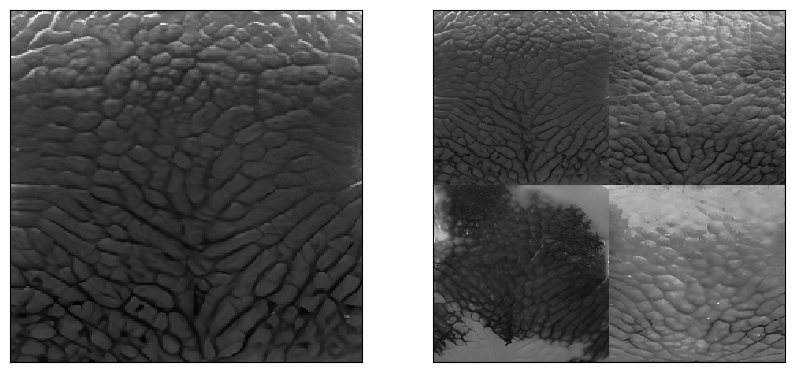

In [ ]:
def concat_images(X):
  nc, h , w, _ = X.shape
  X = X.reshape(nc, h, w)
  n = np.ceil(np.sqrt(nc)).astype("int8")
  img = np.zeros((n*w,n*h))
  x = 0
  y = 0
  for example in range(nc):
    img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
    y += 1
    if y >= n:
      y = 0
      x += 1
  return img


def plot_oneshot_task(pairs):
  fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))
  ax1.matshow(pairs[0][0].reshape(224,224), cmap='gray')
  img = concat_images(pairs[1])
  ax1.get_yaxis().set_visible(False)
  ax1.get_xaxis().set_visible(False)
  ax2.matshow(img,cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.show()

pairs, targets = make_oneshot_task(4,"train")
plot_oneshot_task(pairs)

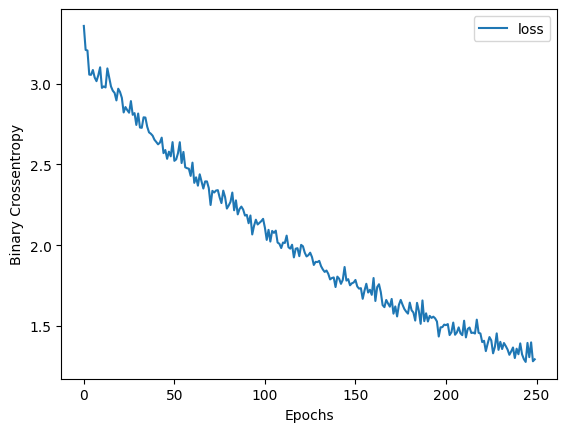

In [ ]:
plt.plot(losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy')
plt.legend()

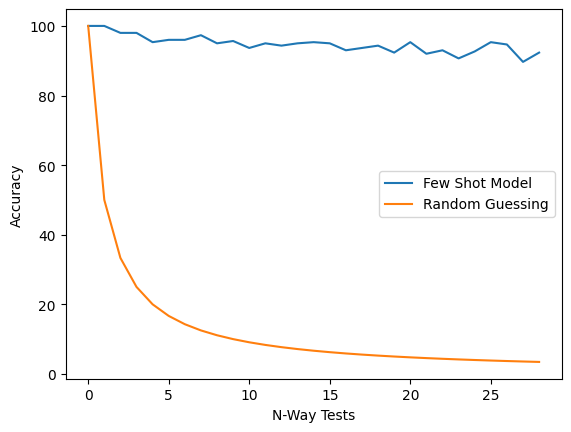

In [ ]:
idx = np.arange(1, 30)
idx = 100/idx
plt.plot(accs, label='Few Shot Model')
plt.plot(idx, label='Random Guessing')
plt.xlabel('N-Way Tests')
plt.ylabel('Accuracy')
plt.legend()